# Algebraic Topological Data Analysis on rs-fMRI data to investigate free energy dynamics
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data. After computing these TDA metrics, we attempt to calculate the free energy of these networks.

## Importing data

**Import libraries**

In [141]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings
warnings.filterwarnings('ignore') 

import timeit

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [142]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

Obtain region names and subnetwork information

In [143]:
# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('./1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('./subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('./subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('./subnet_colors_number.txt')

Plot heatmap of the correlation matrix.

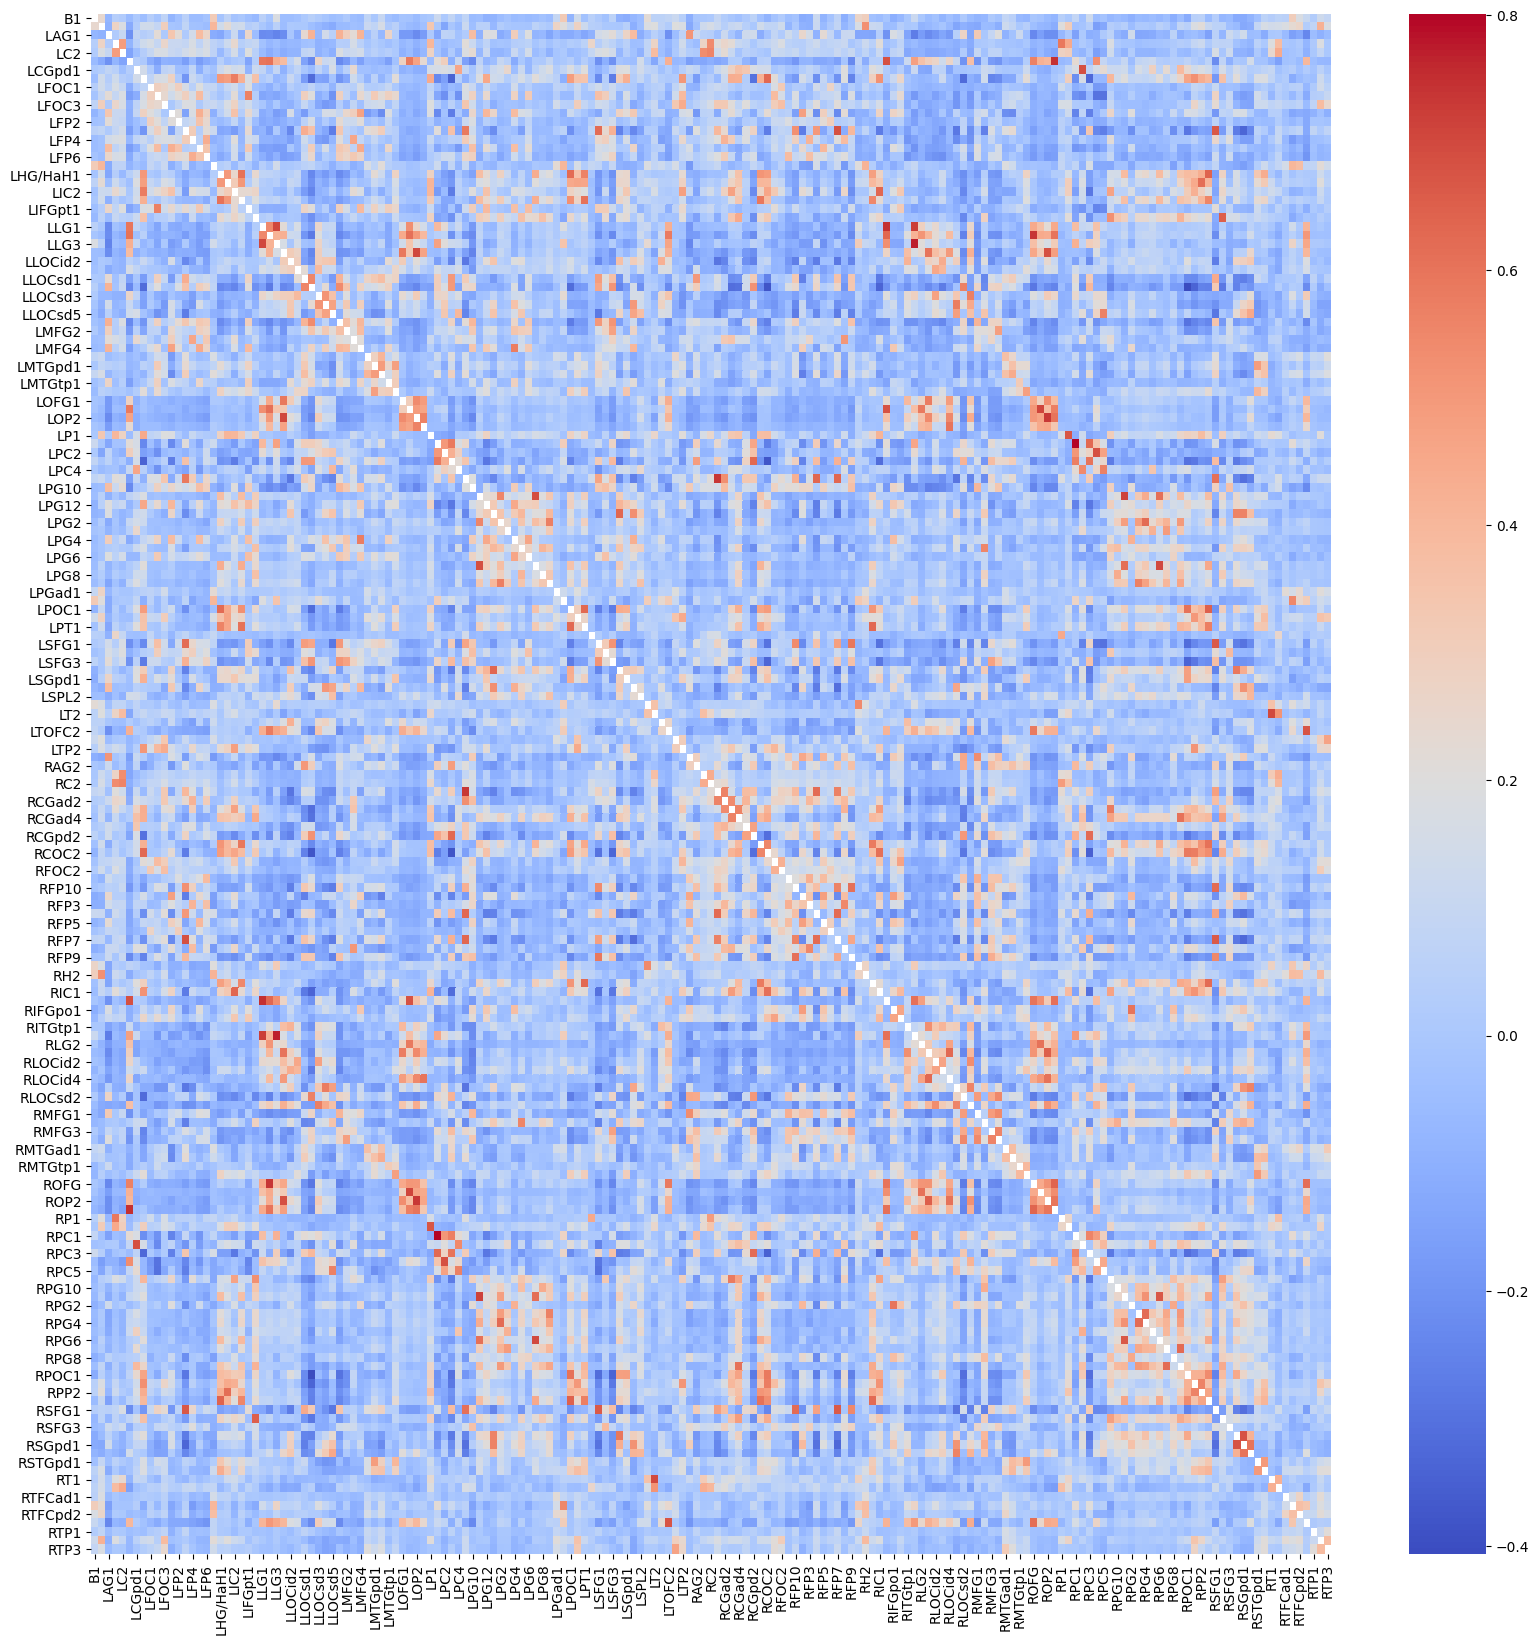

In [144]:
# Creating a DataFrame which will have the rows and column names according to the brain areas
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

# This mask variable gives you the possibility to plot only half of the correlation matrix. 
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None) # To apply the mask, change to mask=mask

## Compute graph metrics

First, absolutise the weighted matrix, so potential biological information from negative correlation is maintained.

In [145]:
# Absolutise for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

Calculate the internal energy, entropy and Helmholtz free energy of the simplicial complex from its connectivity matrix for a given probability distribution and temperature (range)

In [146]:
def free_energy(matrix, probabilities, temperature):
    # Compute Green function (inverse of the connectivity matrix)
    matrix_inverse = np.linalg.inv(matrix)

    # Generate 2d array to multiply with inverse connection matrix
    probability_matrix = np.outer(probabilities, probabilities)

    # Compute internal energy U
    internal_energy = np.sum(np.multiply(matrix_inverse, p_matrix))

    # Compute entropy S
    log_probabilities = np.log(probabilities)
    entropy = sum(np.multiply(probabilities, log_probabilities))

    # Compute free energy F
    free_energy = internal_energy - temperature*entropy

    return internal_energy, entropy, free_energy

# State the required conditions
probabilities = np.array([1/len(matrix)]*len(matrix)) # so use p -> uniform distribution
temperature = 293 # K

internal_energy, entropy, free_energy = free_energy(matrix, probabilities, temperature)

# Return results
print(f'The internal energy U of the simplicial complex G is {internal_energy:.2f}')
print(f'The entropy S of the simplicial complex G is {entropy:.2f}')
print(f'The Hemlholtz free energy F of the simplicial complex G is {free_energy:.2f}')


The internal energy U of the simplicial complex G is 0.00
The entropy S of the simplicial complex G is -5.18
The Hemlholtz free energy F of the simplicial complex G is 1516.61


Calculate the internal energy, entropy and free energy of each subject in the dataset individually and store it as array

In [147]:
import numpy as np
from functools import partial

# State conditions
probabilities = np.array([1/len(matrix)]*len(matrix)) # so use p -> uniform distribution
temperature = 293 # K

# Apply the function to each matrix in the array using numpy
result_array = list(map(partial(free_energy, probabilities=probabilities, temperature=temperature), matrices[0:100]))
result_array = np.array(result_array)

TypeError: the first argument must be callable

Normalise the array so that all the functions have relative quantification

In [ ]:
def normalize_array(array):
    # Ensure that the input array is a numpy array
    array = np.array(array)

    # Find the minimum and maximum values in the array
    min_value = np.min(array)
    max_value = np.max(array)

    # Normalize the array to be between 0 and 1
    normalized_array = (array - min_value) / (max_value - min_value)

    return normalized_array

# Normalize the values in the 3D array
normalized_array = normalize_array(result_array)

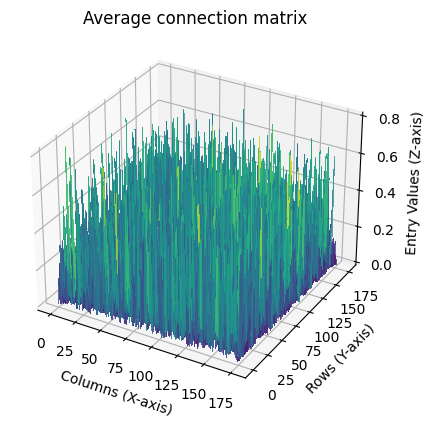

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_array(matrix):
    rows, cols = np.shape(matrix)
    x = np.arange(cols)
    y = np.arange(rows)

    # Create a meshgrid from x and y
    x, y = np.meshgrid(x, y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, matrix, cmap='viridis', alpha=0.7, rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_xlabel('Columns (X-axis)')
    ax.set_ylabel('Rows (Y-axis)')
    ax.set_zlabel('Entry Values (Z-axis)')
    ax.set_title('Average connection matrix')

    plt.show()

plot_3d_array(matrix)


We need to find the probability distribution for the subsets of G. First, calculate the total number of possible subsets if all connections between all vertices are possible.

In [ ]:
from scipy.special import comb

def calculate_groups(n, r):
    combination = comb(n, r, exact=True)
    return combination

def total_groups(n):
    total = sum(calculate_groups(n, r) for r in range(1, n + 1))
    return total

# Example usage:
n = 4  # Number of elements in the set
r = 4 # number of the clique analysis +1
result = calculate_groups(n, r)
print(f"Total number of possible subsets for analysis using a {r-1}-clique: {result}")

Total number of possible subsets for analysis using a 3-clique: 1


Plot the three functionals as scatterplot over all the subjects, so that they can later be arranged on properties like age.

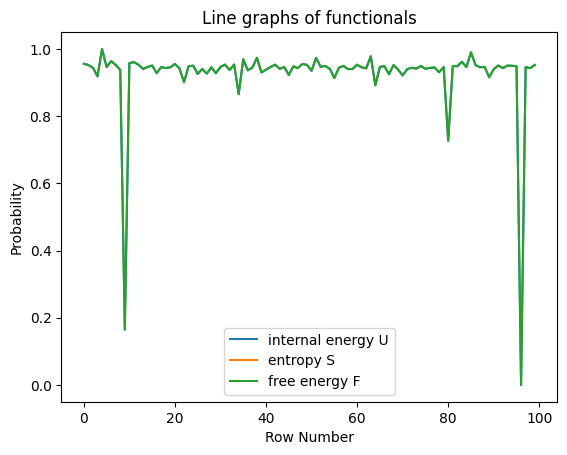

In [ ]:
# Plot the functionals of the simplicial complexes of the brain data
import matplotlib.pyplot as plt

# Extracting columns for each line graph
internal_energy_array = result_array[:, 0]
entropy_array = result_array[:, 1]
free_energy_array = result_array[:, 2]

# Normalise results
internal_energy_array = normalize_array(internal_energy_array)
entropy_array = normalize_array(entropy_array)
free_energy_array = normalize_array(free_energy_array)

# Plotting the three line graphs
plt.plot(range(len(internal_energy_array)),internal_energy_array, label='internal energy U')
plt.plot(range(len(entropy_array)), entropy_array, label='entropy S')
plt.plot(range(len(free_energy_array)), free_energy_array, label='free energy F')

# Setting labels and title
plt.xlabel('Row Number')
plt.ylabel('Probability')
plt.title('Line graphs of functionals')
plt.legend()

# Show the plot
plt.show()


Create a graph from the matrix and remove any self-loops

In [ ]:
# Creating a graph
G = nx.from_numpy_matrix(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

## Visualisation of the network

First, let's get some important attributes about brain area names and subnetworks. These will be used later for graphical visualisation!

In [ ]:
# Function to transform our list of brain areas into a dictionary
def Convert(lst): 
    res_dct = {i : lst[i] for i in range(0, len(lst))} 
    return res_dct

# Add brain areas as attribute of nodes
nx.set_node_attributes(G, Convert(lineList), 'area')

# Add node colors
nx.set_node_attributes(G, Convert(colorlist), 'color')

# Add subnetwork attribute
nx.set_node_attributes(G, Convert(sublist), 'subnet')

# Add node color numbers
nx.set_node_attributes(G, Convert(colornumbs), 'colornumb')

Now we will create a standard spring network plot, but this could also be made circular by changing to *draw_circular*.

We defined the edge widths to the power of 2 so that weak weights will have smaller widths.

In [ ]:
# Standard Network graph with nodes in proportion to Graph degrees
plt.figure(figsize=(30,30))
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=False, width=np.power(edgewidth, 2), edge_color='grey', node_size=normstrengthlist*10000, 
        labels=Convert(lineList), font_color='black', node_color=colornumbs/10, cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
#plt.savefig('network.jpeg')

NameError: name 'normstrengthlist' is not defined

<Figure size 3000x3000 with 0 Axes>

For the sake of a less overwhelming plot, we will work with the st50G graph for the CircosPlot.

In [ ]:
# First let's just add some attributes so that it becomes more interesting

nx.set_node_attributes(st50G, dict(st50G.degree(weight='weight')), 'strength')

nx.set_node_attributes(st50G, Convert(lineList), 'area')

nx.set_node_attributes(st50G, Convert(colorlist), 'color')

nx.set_node_attributes(st50G, Convert(sublist), 'subnet')

#edgecolors = {(e1, e2): int((weight+1)**3) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
#nx.set_edge_attributes(st50G, edgecolors, 'edgecolor')

G_distance_dict2 = {(e1, e2): 1 / abs(weight) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, G_distance_dict2, 'distance')


st50GRL = nx.relabel_nodes(st50G, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(st50GRL, figsize=(30,30), node_labels=True, node_label_layout='rotation', node_order='subnet',
                  edge_color='weight', edge_width='weight', node_color='subnet', node_label_color=True, fontsize=10, 
                  nodeprops={"radius": 2}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = sorted(list(set([list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))])))

plt.legend(handles=circ.legend_handles,
           title="Subnetwork",
           ncol=6,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= labels_networks)

plt.show()

NameError: name 'st50G' is not defined

## Topology and Geometry of the network

**Betti numbers**

A set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that cor-respond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [ ]:
# Import TDA functions
%run "./Background Scripts/TDA.py"

# Compute a sparser graph (10%)
G_d10 = densthr(0.1, matrix)

# Compute Betti number
Betti_k(G_d10, 1)

21

In [ ]:
Betti_list = []

for i in np.arange(0.1,0.3,0.2):
    G = densthr(i, matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list.append(Betti_number)

print(Betti_list)

KeyboardInterrupt: 

**Euler Characteristic**

Another topological invariant is the Euler characteristic. From this value we can compute the Euler entropy of the network.

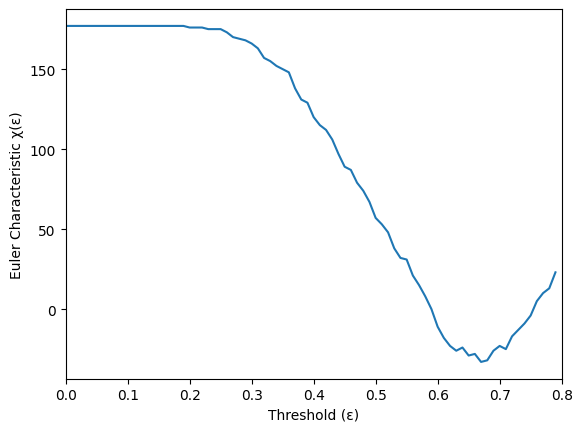

In [ ]:
# Plot the Euler characteristic for a given threshold interval
i = matrix
maxvalue = 80
plt.plot(Eulerchoice_thr(i,maxvalue,0))
plt.xlabel('Threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

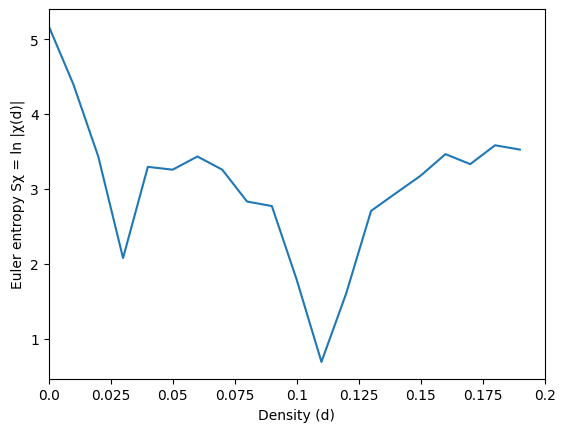

In [ ]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(matrix, 20)